In [1]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split

from utils import ALL_LETTERS, N_LETTERS
from utils import load_data, letter_to_tensor, line_to_tensor, random_training_example

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cpu


In [2]:
class RNN(nn.Module):
    # implementing RNN from scratch rather than using nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [3]:
category_lines, all_categories = load_data()
n_categories = len(all_categories)

n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories).to(device)


In [4]:
#TESTING
# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)
#print(output.size())
#print(next_hidden.size())

# whole sequence/name
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
#print(output.size())
#print(next_hidden.size())

In [5]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

# print(category_from_output(output))

In [6]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

In [7]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss 
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")

5000 5.0 2.9928 Park  / Polish WRONG (Korean)
10000 10.0 2.6870 Durand / Arabic WRONG (French)
15000 15.0 2.4693 Doljs / Greek WRONG (Czech)
20000 20.0 0.0622 Giannakopoulos / Greek CORRECT
25000 25.0 0.2511 Ezakiya / Japanese CORRECT
30000 30.0 2.0511 Oxby / English CORRECT
35000 35.0 0.1591 Brunetti / Italian CORRECT
40000 40.0 0.7356 Trieu / Vietnamese CORRECT
45000 45.0 2.7628 Oelberg / French WRONG (German)
50000 50.0 1.6603 Tron / Vietnamese CORRECT
55000 55.00000000000001 2.0392 Lennon / English WRONG (Irish)
60000 60.0 2.6741 Salazar / Czech WRONG (Portuguese)
65000 65.0 1.9430 Ashia / Arabic WRONG (Japanese)
70000 70.0 1.2604 Naifeh / Irish WRONG (Arabic)
75000 75.0 0.2887 Fernandez / Spanish CORRECT
80000 80.0 1.2252 Jabrev / Russian CORRECT
85000 85.0 0.4308 Min / Chinese CORRECT
90000 90.0 0.4685 Le / Vietnamese CORRECT
95000 95.0 1.2391 Pavlik / Russian WRONG (Czech)
100000 100.0 0.3353 Sugitani / Japanese CORRECT


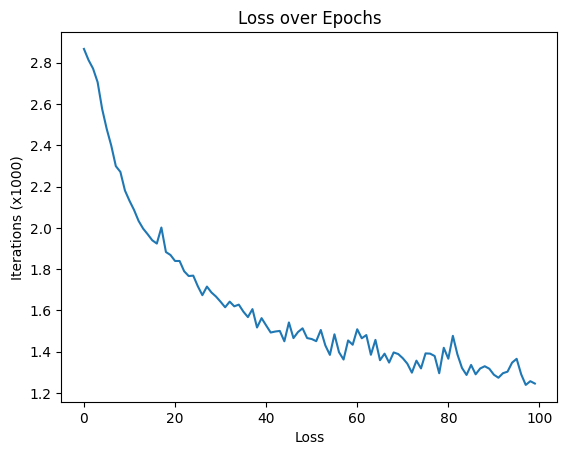

In [8]:
plt.figure()
plt.plot(all_losses)
plt.title('Loss over Epochs')
plt.xlabel('Loss')
plt.ylabel('Iterations (x1000)')
plt.show()

In [9]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_from_output(output)
        print(guess)

In [10]:
# User inputted Prediction Test
sentence = ("Albert")
predict(sentence)


> Albert
French


In [11]:
#Accuracy Test
def eval(test_data):
    correct = 0
    total = 0
    
    with torch.no_grad():
        for category, lines in test_data.items():
            for line in lines:
                category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long).to(device)
                line_tensor = line_to_tensor(line).to(device)
                
                hidden = rnn.init_hidden().to(device)
                
                for i in range(line_tensor.size()[0]):
                    output, hidden = rnn(line_tensor[i], hidden)
                
                guess = category_from_output(output)
                if guess == category:
                    correct += 1
                total += 1
                
    accuracy = correct / total * 100
    print(f"Accuracy: {accuracy:.2f}% ({correct}/{total})")

In [12]:
train_data, test_data = train_test_split(category_lines, test_size=0.2, random_state=42)
eval(test_data)

KeyError: np.int32(3)